# Presentation on LinearSolve.jl

This is a notebook that will explore the questions of how the package **LinearSolve.jl** is relevant to numerical computing.

### Metrics and Features
- This [video](https://www.youtube.com/watch?v=JWI34_w-yYw) goes into detail over why LinearSolver.jl and specifically it's LU factorization is more optimized but I want to run some simple metrics myself and show you that it can perform better

In [313]:
import Pkg
Pkg.add("LinearSolve")
Pkg.add("ProfileSVG")
Pkg.add("Profile")
Pkg.add("Test")
# Pkg.add("ProfileView")
# Pkg.add("FlameGraphs")
Pkg.add("Plots")
import LinearSolve as LS
import LinearAlgebra as LA

In [314]:
n = 10
A = rand(n, n)
b1 = rand(n);
prob = LS.LinearProblem(A, b1)


linsolve = LS.init(prob)
sol1 = LS.solve!(linsolve)

# @show A \ b1
# @show sol1
println("A =")
show(stdout, "text/plain", A)

println("\n\nSolving with `A\\b`: \nx =")
show(stdout, "text/plain", A \ b1)
# display(A \ b1);

println("\n\nSolving with LinearSolve.jl: \nx =")
show(stdout, "text/plain", sol1)
# display(sol1);

In [315]:
@time LS.LinearProblem(A, b1)
@time LS.init(prob)
@time LS.solve!(linsolve)
@time A \ b1;

Here we can see that with a relatively small matrix that LinearSolve is relatively slow and takes more space. However, let's try with a couple bigger matrices. 

In [316]:
n = 100
A = rand(n, n)
b1 = rand(n);
prob = LS.LinearProblem(A, b1)
linsolve = LS.init(prob)
sol1 = LS.solve!(linsolve)

@time LS.LinearProblem(A, b1)
@time LS.init(prob)
@time LS.solve!(linsolve)
@time A \ b1;

In [317]:
n = 1000
A = rand(n, n)
b1 = rand(n);
prob = LS.LinearProblem(A, b1)
linsolve = LS.init(prob)
sol1 = LS.solve!(linsolve)

@time LS.LinearProblem(A, b1)
@time LS.init(prob)
@time LS.solve!(linsolve)
@time A \ b1;

In [318]:
n = 10000
A = rand(n, n)
b1 = rand(n);
prob = LS.LinearProblem(A, b1)
linsolve = LS.init(prob)
sol1 = LS.solve!(linsolve)

@time LS.LinearProblem(A, b1)
@time LS.init(prob)
@time LS.solve!(linsolve)
@time A \ b1;

As you can see, while the memory usage is ever so slightly more in using the LinearSolve package, we can see it is way faster by almost 10x or more depending on the size of the matrix. 

We then can try seeing what the accuracy looks like with the normilated error as we increase the size of A. 

In [319]:
# Hide this cell

# function run_sim_def(sim_amt, n)
#     sims = zeros(sim_amt, 2)
#     for k in 1:sim_amt
#         A = rand(n, n);
#         true_b = rand(n);
#         x = profile_test_default(A, true_b);
#         sims[k, 1] = @elapsed profile_test_default(A, true_b)
#         sims[k, 2] = LA.norm(true_b - A*x)
#     end
#     sims
# end

In [320]:
using Plots

function profile_test_LinearSolve(A, b)
    prob = LS.LinearProblem(A, b)
    linsolve = LS.init(prob)
    x = LS.solve!(linsolve)
    x
end

function profile_test_default(A, b)
    x = A \ b
    x
end

function run_sim(sim_amt, n)
    sims = zeros(sim_amt, 4)
    for k in 1:sim_amt
        A = rand(n, n);
        true_b = rand(n);
        x1 = profile_test_LinearSolve(A, true_b);
        sims[k, 1] = @elapsed profile_test_LinearSolve(A, true_b)
        sims[k, 2] = LA.norm(true_b - A*x1)
        
        x2 = profile_test_default(A, true_b)
        sims[k, 3] = @elapsed profile_test_default(A, true_b)
        sims[k, 4] = LA.norm(true_b - A*x2)
    end
    sims
end

sim_amt = 100
n = 200;
sims = run_sim(sim_amt, n);

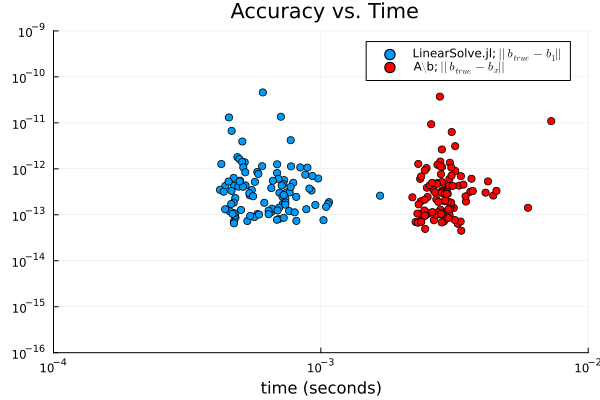

In [321]:
# lin = run_sim_lin(sim_amt, n)
# yscale=:log10,
scatter(sims[:, 1], sims[:, 2], 
        yscale=:log10, 
        xscale=:log10,
        ylims=(1e-16, 1e-9), xlims=(1e-4, 1e-2), 
        label="LinearSolve.jl; \$\\vert \\vert b_{true} - b_1 \\vert \\vert\$", 
        xlabel="time (seconds)", 
        title=" Accuracy vs. Time")

scatter!(sims[:, 3], sims[:, 4],
        label="A\$\\backslash\$b; \$\\vert \\vert b_{true} - b_x \\vert \\vert\$", 
        color = :red)

As you can see with the graphs above, LinearSolve.jl actually is about the roughly about the same accuracy as `A\b`, however the speed up is much faster with LinearSolve. 

### Answering previous question (New Section)
Originally I had asked the question of "how does LinearSolver achieve better optimization than BLAS?" I am here to explore that now!

Looking through the documentation, we can see that once we have defined the LinearProblem with the $A$ matrix as well as the $b$ vector. And then we solve that problem. There is an automatic algorithm selector that takes in consideration these factors (taken directly from the [docs](https://docs.sciml.ai/LinearSolve/stable/basics/algorithm_selection/)):
* Matrix type: Dense vs. sparse vs. structed matrices
* Matrix properties: Square vs. rectangular, symmetric positive definite 
* Size: Small vs. large matrices for performance optimization
* Hardware: CPU vs. GPU arrays
* Conditioning: Well-conditioned vs. ill-conditioned systems

The automatic selection then goes through these processes to determine how to best solve for $b$ (also taken from the docs):
```
Is A diagonal? 
    → DiagonalFactorization

Is A tridiagonal/bidiagonal? 
    → DirectLdiv! (Julia 1.11+) or LUFactorization  

Is A symmetric positive definite? 
    → CholeskyFactorization

Is A symmetric indefinite? 
    → BunchKaufmanFactorization

Is A sparse? 
    → UMFPACKFactorization or KLUFactorization

Is A small dense? 
    → RFLUFactorization or SimpleLUFactorization

Is A large dense? 
    → MKLLUFactorization, OpenBLASLUFactorization, or AppleAccelerateLUFactorization

Is A GPU array? 
    → QRFactorization or LUFactorization

Is A an operator/function? 
    → KrylovJL_GMRES

Is the system overdetermined? 
    → QRFactorization or KrylovJL_LSMR
```

From here I want to take a look at how they implemented the Cholesky factorization, KrylovJL_GMRES, and finally the QR factorization.

#### Cholesky Factorization

The implemented CholeskyFactorization uses Julia's built in `cholesky`, so is in essence the same as calling `cholesky!(A)`. Here is the specific code for the factorization:

In [322]:
# Hide this cell
Pkg.add("SciMLBase")
import SciMLBase

```julia

abstract type SciMLLinearSolveAlgorithm <: SciMLBase.AbstractLinearAlgorithm end
abstract type AbstractFactorization <: SciMLLinearSolveAlgorithm end
abstract type AbstractDenseFactorization <: AbstractFactorization end
"""
`CholeskyFactorization(; pivot = nothing, tol = 0.0, shift = 0.0, perm = nothing)`

Julia's built in `cholesky`. Equivalent to calling `cholesky!(A)`.

## Keyword Arguments

  - pivot: defaluts to NoPivot, can also be RowMaximum.
  - tol: the tol argument in CHOLMOD. Only used for sparse matrices.
  - shift: the shift argument in CHOLMOD. Only used for sparse matrices.
  - perm: the perm argument in CHOLMOD. Only used for sparse matrices.
"""

struct CholeskyFactorization{P, P2} <: AbstractDenseFactorization
    pivot::P
    tol::Int
    shift::Float64
    perm::P2
end

function CholeskyFactorization(; pivot = nothing, tol = 0.0, shift = 0.0, perm = nothing)
    pivot === nothing && (pivot = NoPivot())
    CholeskyFactorization(pivot, 16, shift, perm)
end

function do_factorization(alg::CholeskyFactorization, A, b, u)
    A = convert(AbstractMatrix, A)
    if issparsematrixcsc(A)
        fact = cholesky(A; shift = alg.shift, check = false, perm = alg.perm)
    elseif A isa GPUArraysCore.AnyGPUArray
        fact = cholesky(A; check = false)
    elseif alg.pivot === Val(false) || alg.pivot === NoPivot()
        fact = cholesky!(A, alg.pivot; check = false)
    else
        fact = cholesky!(A, alg.pivot; tol = alg.tol, check = false)
    end
    return fact
end
```

This is a pretty boring but efficient implementation as the one in class that struggled was due to the vandermonde being a terrible matrix so I would like to compare the two with some random matrices. I will also use the one that was fixed the Cholesky implementation as well.

In [323]:
Pkg.add("Polynomials")
using Polynomials

In [324]:
# LinearSolve.jl
function profile_test_ch_ln(A, b)
    # Have to solve for the least squares problem 
    AtA = A' * A
    Atb = A' * b
    prob = LS.LinearProblem(AtA, Atb)
    linsolve = LS.init(prob, LS.CholeskyFactorization())
    x = LS.solve!(linsolve)
    x
end

# Helper function
function qr_chol(A)
    R = LA.cholesky(A' * A).U
    Q = A / R
    Q, R
end

# Cholesky class example 1
function profile_test_ch1(A, b)
    R = LA.cholesky(A' * A).U
    Q = A / R
    x = R \ (Q' * b)
    x
end

# Cholesky class example 2
function profile_test_ch2(A, b)
    Q, R = qr_chol(A)  # QR factorization
    Q, R1 = qr_chol(Q) # And again
    # Q, R1 * R
    newR = R1* R
    x = newR \ (Q' * b)
    x
end

function run_sim(sim_amt, n)
    sims = zeros(sim_amt, 6)
    for k in 1:sim_amt
        A = rand(n, n);
        true_b = rand(n);
        t = @elapsed x1 = profile_test_ch_ln(A, true_b)
        sims[k, 1] = t
        sims[k, 2] = LA.norm(true_b - A*x1)

        t = @elapsed x2 = profile_test_ch1(A, true_b)
        sims[k, 3] = t
        sims[k, 4] = LA.norm(true_b - A*x2)
        
        t = @elapsed x3 = profile_test_ch2(A, true_b)
        sims[k, 5] = t
        sims[k, 6] = LA.norm(true_b - A*x3)
    end
    sims
end

sim_amt = 50
n = 100;
sims = run_sim(sim_amt, n);

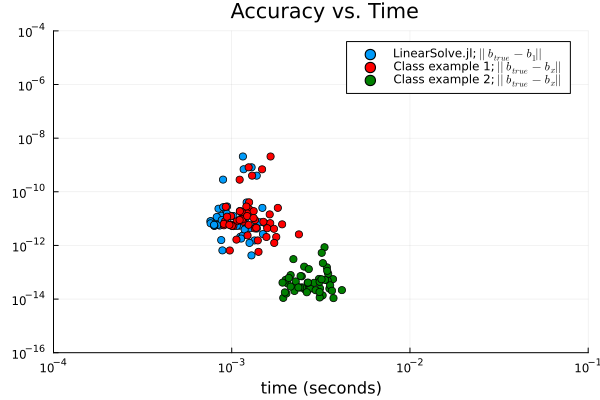

In [325]:
scatter(sims[:, 1], sims[:, 2], 
        yscale=:log10, 
        xscale=:log10,
        ylims=(1e-16, 1e-4), xlims=(1e-4, 1e-1), 
        label="LinearSolve.jl; \$\\vert \\vert b_{true} - b_1 \\vert \\vert\$", 
        xlabel="time (seconds)", 
        title=" Accuracy vs. Time")

scatter!(sims[:, 3], sims[:, 4],
        label="Class example 1; \$\\vert \\vert b_{true} - b_x \\vert \\vert\$", 
        color = :red)

scatter!(sims[:, 5], sims[:, 6],
        label="Class example 2; \$\\vert \\vert b_{true} - b_x \\vert \\vert\$", 
        color = :green)

So looking at the graph above, we can tell that error between LinearSolve and our implementations within class and see that they aren't really that different. However, this is using their Cholesky with a nonoptimal problem (i.e. in this case, a least squares problem). Cholesky should be great for an SPD matrix so let's explore that as well.

In [326]:
function run_sim(sim_amt, n)
    sims = zeros(sim_amt, 6)
    for k in 1:sim_amt
        G = rand(n, n);
        # I_n = Matrix(I, n, n)
        I_n = LA.I
        A = G' * G + n* I_n # Almost guarantees SPD
        true_b = rand(n);
        t = @elapsed x1 = profile_test_ch_ln(A, true_b)
        sims[k, 1] = t
        sims[k, 2] = LA.norm(true_b - A*x1)

        t = @elapsed x2 = profile_test_ch1(A, true_b)
        sims[k, 3] = t
        sims[k, 4] = LA.norm(true_b - A*x2)
        
        t = @elapsed x3 = profile_test_ch2(A, true_b)
        sims[k, 5] = t
        sims[k, 6] = LA.norm(true_b - A*x3)
    end
    sims
end

sim_amt = 50
n = 100;
sims = run_sim(sim_amt, n);

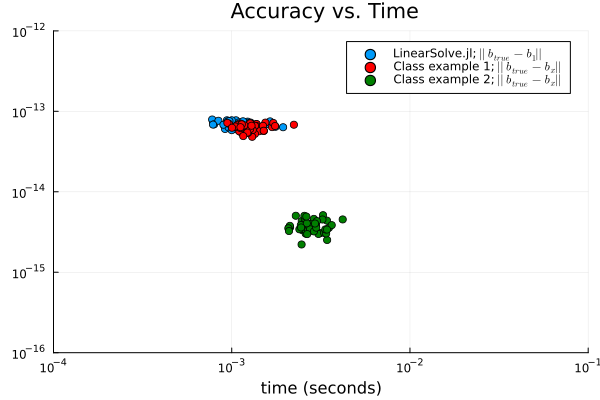

In [327]:
scatter(sims[:, 1], sims[:, 2], 
        yscale=:log10, 
        xscale=:log10,
        ylims=(1e-16, 1e-12), xlims=(1e-4, 1e-1), 
        label="LinearSolve.jl; \$\\vert \\vert b_{true} - b_1 \\vert \\vert\$", 
        xlabel="time (seconds)", 
        title=" Accuracy vs. Time")

scatter!(sims[:, 3], sims[:, 4],
        label="Class example 1; \$\\vert \\vert b_{true} - b_x \\vert \\vert\$", 
        color = :red)

scatter!(sims[:, 5], sims[:, 6],
        label="Class example 2; \$\\vert \\vert b_{true} - b_x \\vert \\vert\$", 
        color = :green)

So even with an ideal SPD matrix, yes it is slightly faster than both our in class implementations of Cholesky. However, with a slightly longer runtime, we can get about 10 times more accuracy. But yeah that was the analysis of the Cholesky from LinearSolve.

#### KrylovJL_GMRES
For any of the Krylov methods, they set up a wrapper for the appropriate Krylov method (i.e. GMRES, CG, MinRes, etc.) and then use an external implementation using all the main Krylov implementation libraries; Krylov.jl, IterativeSolvers.jl, KrylovKit.jl.

The reason for the wrapper is to make it more accessible for people using LinearSolve and also incorporting the necessities for each of the implementation libraries. But I think it would be interesting to explore the convergence of the of the Krylov Subspace approximation. Below is a sample of the wrapper:

```julia
KrylovJL_GMRES(args...; gmres_restart = 0, window = 0, kwargs...)
"""
A generic GMRES implementation for square non-Hermitian linear systems
"""
function KrylovJL_GMRES(args...; kwargs...)
    KrylovJL(args...; KrylovAlg = Krylov.gmres!, kwargs...)
end

```

In [328]:
# Helper functions
function class_arnoldi(A, b, k=nothing)
    """Form the Krylov subspace from the initial vector b and the matrix A.
    This function returns a pair of matrices Q, H.
    The columns of Q are the orthonormalized basis vectors for the Krylov space.
    H is upper Hessenberg and holds the normalization factors.
    """
    # Get our dimensions for the subspace
    n, _ = size(A)
    if isnothing(k)
        k = n
    end
    # Build a matrix to hold the subspace and initialize it
    Q = zeros(n, k+1)
    # Let's put our factors here, similar to QR
    H = zeros(k+1, k)
    r = LA.norm(b)
    Q[:, 1] = b / r
    for i in 2:k+1
        v = A * Q[:, i-1]
        for j in 1:i
            ### BEGIN SOLUTION]
            H[j, i-1] = Q[:, j]'*v
            v = v - H[j, i-1]*Q[:, j]
            ### END SOLUTION
        end
        r = LA.norm(v)
        # We need to stop if the norm of v is small
        #  This means v ≈ 0
        if r < 1e3 * eps()
            break
        end
        Q[:, i] = v / r
        H[i, i-1] = r
    end
    Q, H
end

function class_arnoldi_update(A, Q, H)
    """Update the Krylov subspace from the initial vector b and the matrix A.
    This function returns an updated pair of matrices Q, H.
    Q has a new column for the next orthonormal vector and H has the updated factors.
    """
    # Get our dimensions for the subspace
    n, k = size(Q)
    # Build a new Q
    # This is inefficient but shows the idea
    Q_new = zeros(n, k+1)
    Q_new[:, 1:k] = Q
    # And a new H
    H_new = zeros(k+1, k)
    H_new[1:k, 1:k-1] = H
    # Compute new Krylov vector
    v = A * Q_new[:, k]
    for j in 1:k
        ### BEGIN SOLUTION
        H_new[j, k] = Q_new[:, j]'*v
        v = v - H_new[j, k]*Q_new[:, j]
        ### END SOLUTION
    end
    r = LA.norm(v)
    # We need to stop if the norm of v is small
    #  This means v ≈ 0
    if r > 1e3 * eps()
        Q_new[:, k+1] = v / r
        H_new[k+1, k] = r
    end
    Q_new, H_new
end

class_arnoldi_update (generic function with 1 method)

In [329]:
Pkg.add("Krylov")
Pkg.add("LinearOperators")

In [330]:
# LinearSolve.jl
# using Krylov
# using LinearSolve
# using LinearOperators

function profile_test_ln_gmres(A, b)
    AtA = A' * A
    Atb = A' * b

    res_hist = Float64[]

    prob = LS.LinearProblem(AtA, Atb)
    alg = LS.KrylovJL_GMRES()

    # linsolve = LS.init(prob, alg; verbose=true)
    linsolve = LS.init(prob, alg; verbose=false)
    x = LS.solve!(linsolve)

    # Had to use chat to help debug this because 
        # the path to get the residuals was super unclear
    # @show typeof(linsolve.cacheval.stats)
    # @show fieldnames(typeof(linsolve.cacheval.stats))

    res_hist = copy(linsolve.cacheval.stats.residuals)
    # @show res_hist

    return x, res_hist
end


# Cholesky class example
function profile_test_gmres(A, b)
    # Form the initial Krylov subspace
    AtA = A' * A
    Atb = A' * b
    k_max = 55

    A = AtA
    b = Atb

    k = 1
    Q, H = class_arnoldi(A, b, k)

    # Solve the least squares problem
    β = LA.norm(b)
    e1 = zeros(k+1)
    e1[1] = 1
    c = H \ (β*e1)
    xk = Q[:, 1:k] * c
    
    r = zeros(k_max)
    r[k] = LA.norm(b - A * xk)

    # And see how well our solution matches as we increase k
    for k = 2:k_max
        # Update the Krylov subspace
        Q, H = class_arnoldi_update(A, Q, H)

        # Solve the least squares problem
        β = LA.norm(b)
        e1 = zeros(k+1)
        e1[1] = 1
        c = H \ (β*e1)
        xk = Q[:, 1:k] * c

        # And calculate the latest residual
        r[k] = LA.norm(b - A * xk)
    end

    return xk, r ./ LA.norm(b)
end

function run_sim(n)
    A = rand(n, n);
    true_b = rand(n);

    xk1, hist1 = profile_test_ln_gmres(A, true_b)
    xk2, hist2 = profile_test_gmres(A, true_b)

    return xk1, hist1, xk2, hist2, A, true_b
end

# sim_amt = 50
# n = 100;
# sims = run_sim(sim_amt, n);
lin_solved_x, lin_his, class_solved_x, class_his, A_mat, b_vec = run_sim(50);
k_max = 55;
# @show lin_his;

55

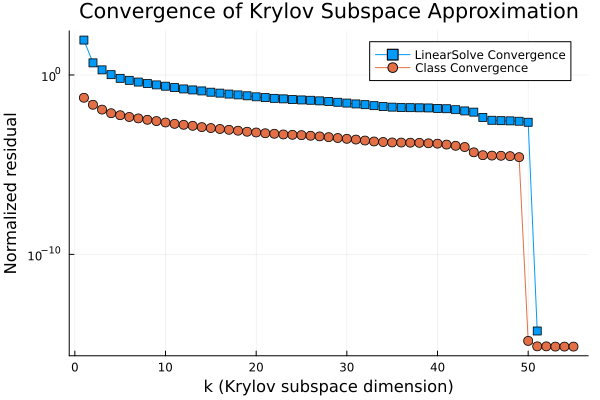

In [331]:
plot(1:length(lin_his), lin_his, 
    yscale = :log10,
    xlabel = "k (Krylov subspace dimension)", 
    ylabel = "Normalized residual",
    title = "Convergence of Krylov Subspace Approximation",
    label= "LinearSolve Convergence",
    marker = :square)

plot!(1:k_max, class_his, 
    yscale = :log10,
    # legend = false,
    label= "Class Convergence",
    marker = :circle, markersize=5)


As you can see, the convergence of both Krylov Subspace Approximations are roughly the same shape, however the LinearSolve convergence starts off worse but then reaches about the same normalized residual so we know that at least they use both very similar code. So let's check if the solutions also match up. 

In [332]:
@show LA.norm(b_vec - A_mat*lin_solved_x)
@show LA.norm(b_vec - A_mat*class_solved_x);

That's pretty fire to see, and you are welcome to mess around more with this since it was super annoying trying to figure out how to get the residuals from LinearSolve. So let's move on and examine QR Factorization.

#### QR Factorization
For this section, I want to compare just the accuracy again but on non-square matrices. In this case an overdetermined matrix.

So what exactly is an overdetermined matrix, well it is used when the number of equations outnumbers the amount of variables. Creating a matrix that has more rows then columns.

Here is what the code looks like and let's get into it:
```julia
"""
`QRFactorization(pivot=LinearAlgebra.NoPivot(),blocksize=16)`

Julia's built in `qr`. Equivalent to calling `qr!(A)`.

  - On dense matrices, this uses the current BLAS implementation of the user's computer
    which by default is OpenBLAS but will use MKL if the user does `using MKL` in their
    system.
  - On sparse matrices, this will use SPQR from SparseArrays
  - On CuMatrix, it will use a CUDA-accelerated QR from CuSolver.
  - On BandedMatrix and BlockBandedMatrix, it will use a banded QR.
"""
struct QRFactorization{P} <: AbstractDenseFactorization
    pivot::P
    blocksize::Int
    inplace::Bool
end

QRFactorization(inplace = true) = QRFactorization(NoPivot(), 16, inplace)

function QRFactorization(pivot::LinearAlgebra.PivotingStrategy, inplace::Bool = true)
    QRFactorization(pivot, 16, inplace)
end

function do_factorization(alg::QRFactorization, A, b, u)
    A = convert(AbstractMatrix, A)
    if ArrayInterface.can_setindex(typeof(A))
        if alg.inplace && !issparsematrixcsc(A) && !(A isa GPUArraysCore.AnyGPUArray)
            if A isa Symmetric
                fact = qr(A, alg.pivot)
            else
                fact = qr!(A, alg.pivot)
            end
        else
            fact = qr(A) # CUDA.jl does not allow other args!
        end
    else
        fact = qr(A, alg.pivot)
    end
    return fact
end
```

In [333]:
# Helper Functions
function gram_schmidt_modified(A)
    m, n = size(A)
    Q = copy(A)
    R = zeros(n, n)
    for j in 1:n
        # First we normalize our column
        R[j, j]  = LA.norm(Q[:, j])
        Q[:, j] /= R[j, j]
        # Then we make all following columns orthogonal to the current
        R[j, j+1:end]  = Q[:, j]' * Q[:, j+1:end]
        Q[:, j+1:end] -= Q[:, j]  * R[j, j+1:end]'
    end
    Q, R
end

function qr_householder(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        # Build v for the current column
        v = copy(R[j:end, j])
        v[1] += sign(v[1]) * LA.norm(v) # Here's the fix!
        v = LA.normalize(v)
        # Build and apply F
        R[j:end, j:end] -= 2 * v * (v' * R[j:end,j:end])
        # Keep track of the reflectors
        push!(V, v)
    end
    V, R
end

# Here's a function to apply the reflectors V to a vector x
function reflectors_mult(V, x)
    y = copy(x)
    for v in reverse(V)
        n = length(v) - 1
        # This is applying F as we did to form R
        y[end-n:end] -= 2 * v * (v' * y[end-n:end])
    end
    y
end

# Create a dense matrix Q from reflectors V
function reflectors_to_dense(V)
    m = length(V[1])
    Q = LA.diagm(ones(m))
    # Apply the reflectors to the identity matrix to build Q
    for j in 1:m
        Q[:, j] = reflectors_mult(V, Q[:,j])
    end
    Q
end


reflectors_to_dense (generic function with 1 method)

In [334]:
# LinearSolve.jl
function profile_test_qr_ln(A, b)
    prob = LS.LinearProblem(A, b)
    linsolve = LS.init(prob, LS.QRFactorization())
    # linsolve = LS.init(prob)
    x = LS.solve!(linsolve)
    x
end

# QR class example 1
function profile_test_qr1(A, b)
    Q, R = gram_schmidt_modified(A)
    x = R \ (Q' * b)
    x
end

# QR householder class example 2
function profile_test_qr2(A, b)
    # Q, R = gram_schmidt_modified(A)
    V, R = qr_householder(A)
    Q = reflectors_to_dense(V)
    x = R \ (Q' * b)
    x
end

function run_sim(sim_amt, n, m)
    sims = zeros(sim_amt, 6)

    for k in 1:sim_amt
        # A = rand(n, m) ./ rand(n, m)
        A = rand(n, m)
        # @show A
        x_true = rand(m);
        true_b = A*x_true;
        # true_b = rand(n);
        t = @elapsed x1 = profile_test_qr_ln(A, true_b)
        sims[k, 1] = t
        sims[k, 2] = LA.norm(true_b - A*x1)

        t = @elapsed x2 = profile_test_qr1(A, true_b)
        sims[k, 3] = t
        sims[k, 4] = LA.norm(true_b - A*x2)
        
        t = @elapsed x3 = profile_test_qr2(A, true_b)
        sims[k, 5] = t
        sims[k, 6] = LA.norm(true_b - A*x3)
    end
    sims
end

sim_amt = 50
n = 1000;
m = 50;

# n = 3;
# m = 2;
sims = run_sim(sim_amt, n, m);

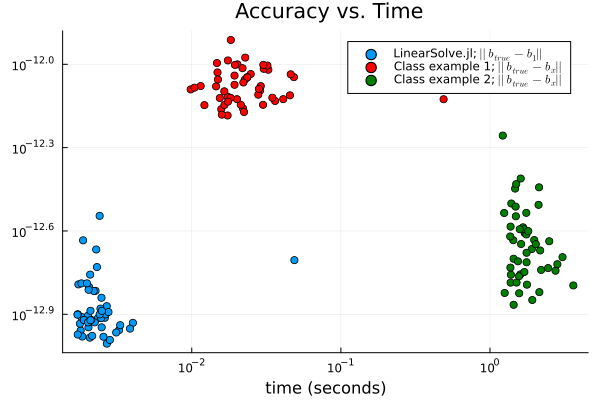

In [335]:
scatter(sims[:, 1], sims[:, 2], 
        yscale=:log10, 
        xscale=:log10,
        # ylims=(1e-16, 1e-4), xlims=(1e-4, 1e-1), 
        label="LinearSolve.jl; \$\\vert \\vert b_{true} - b_1 \\vert \\vert\$", 
        xlabel="time (seconds)", 
        title=" Accuracy vs. Time")

scatter!(sims[:, 3], sims[:, 4],
        label="Class example 1; \$\\vert \\vert b_{true} - b_x \\vert \\vert\$", 
        color = :red)

scatter!(sims[:, 5], sims[:, 6],
        label="Class example 2; \$\\vert \\vert b_{true} - b_x \\vert \\vert\$", 
        color = :green)

As you can see, with an overdetermined matrix, they all perform pretty good. However, if you want speed and accuracy, then using the LinearSolve package is the way. While the other two either trade-off speed for accuracy or visa versa.

### Other Optimization
Below is an optimization option. I didn't want to explore too much of this one because I don't think my computer could handle making large matrices. However, this option is an exploration for you if you want to understand more about how this application can be applied to Machine Learning with their massive matrices and matrix multiplication:

Preconditioners ([Doc link](https://docs.sciml.ai/LinearSolve/stable/basics/Preconditioners/))

### Conclusion
As you can see the LinearSolve package is really cool and has a lot to work with. And while it may not be the best in everything. It makes up by being one of the fastest packages out there especially for handling matrix operations and solving for large matrices.